# Visualizing cluster feature heatmaps and survival curves

This notebook illustrates how to generate the cluster feature heatmap and cluster survival curve plots in our paper.

Author: George H. Chen (georgechen [at symbol] cmu.edu)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
%config InlineBackend.figure_format='retina'
from lifelines import KaplanMeierFitter
plt.style.use('seaborn')
import seaborn as sns
sns.color_palette('pastel')

from visualization_utils import transform, heatmap_plot, compute_SFT_survival_curves, compute_median_survival_times

### Load in data & auxiliary information

In [2]:
dataset = 'support'
visualization_dir = 'example_out_kernets_nosplit/visualization/kernet_tuna=xgb_support_exp0_pf1.000000_a0.010000_s0.100000_nd0_g0.000000_b0.500000_mkw0.100000_sr0.100000_nn128_nla2_nno128_bs1024_nep22_lr0.010000_sft'
raw_features = np.load(os.path.join(visualization_dir, 'train_raw_input.npy'))
labels = np.load(os.path.join(visualization_dir, 'train_labels.npy'))
duration_index = np.load(os.path.join(visualization_dir, 'duration_index.npy'))
embeddings = np.load(os.path.join(visualization_dir, 'train_embeddings.npy'))
exemplar_assignments = np.load(os.path.join(visualization_dir, 'exemplar_assignments.npy'), allow_pickle=True)
exemplar_labels = np.load(os.path.join(visualization_dir, 'exemplar_labels.npy'))
baseline_event_counts = np.load(os.path.join(visualization_dir, 'baseline_event_counts.npy'))
baseline_at_risk_counts = np.load(os.path.join(visualization_dir, 'baseline_at_risk_counts.npy'))
n_exemplars = len(exemplar_assignments)
exemplar_sizes = [len(exemplar_assignments[idx]) for idx in range(len(exemplar_assignments))]
exemplar_embeddings = embeddings[np.array([_[0] for _ in exemplar_assignments], dtype=int)]
units = 'days'

In [3]:
print('Number of exemplars/clusters:', n_exemplars)

Number of exemplars/clusters: 34


In [4]:
# compute survival curves from summary fine-tuning (SFT)
exemplar_SFT_survival_curves = compute_SFT_survival_curves(exemplar_labels, baseline_event_counts, baseline_at_risk_counts)

In [5]:
# compute each cluster's Kaplan-Meier curve & max observed time
exemplar_kaplan_meier_curves = []
max_observed_times = []
for exemplar_idx in range(n_exemplars):
    exemplar_kaplan_meier_curves.append(KaplanMeierFitter())
    observed_times, event_indicators = labels[exemplar_assignments[exemplar_idx]].T
    exemplar_kaplan_meier_curves[-1].fit(observed_times, event_indicators)
    max_observed_times.append(observed_times.max())
max_observed_times = np.array(max_observed_times)

/var/folders/ms/yzwxs7r54nx0q978svcpsnbh0000gn/T/ipykernel_97160/1345181453.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


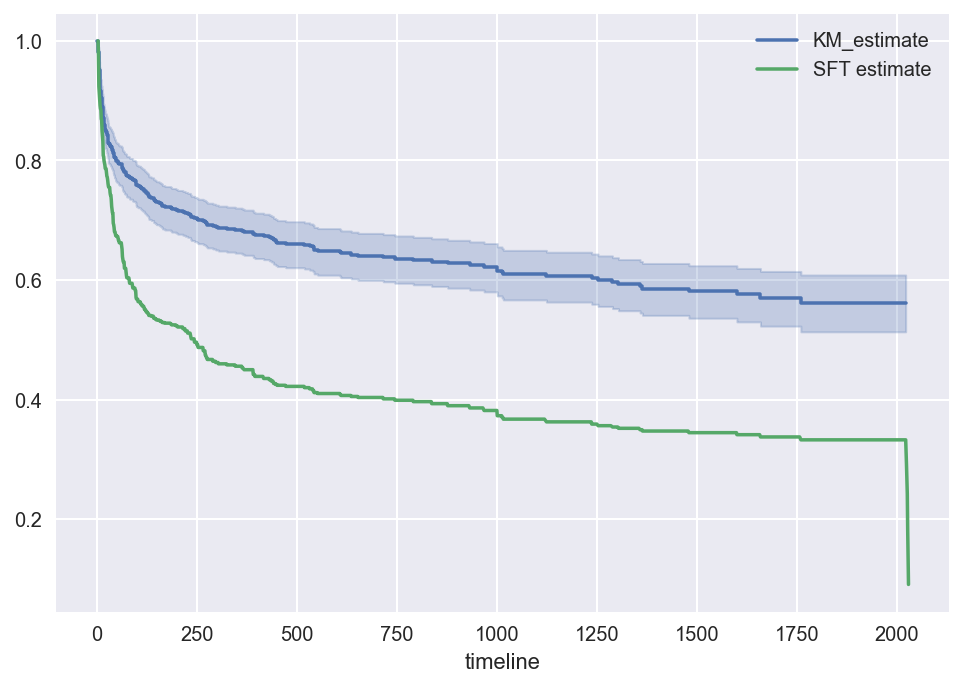

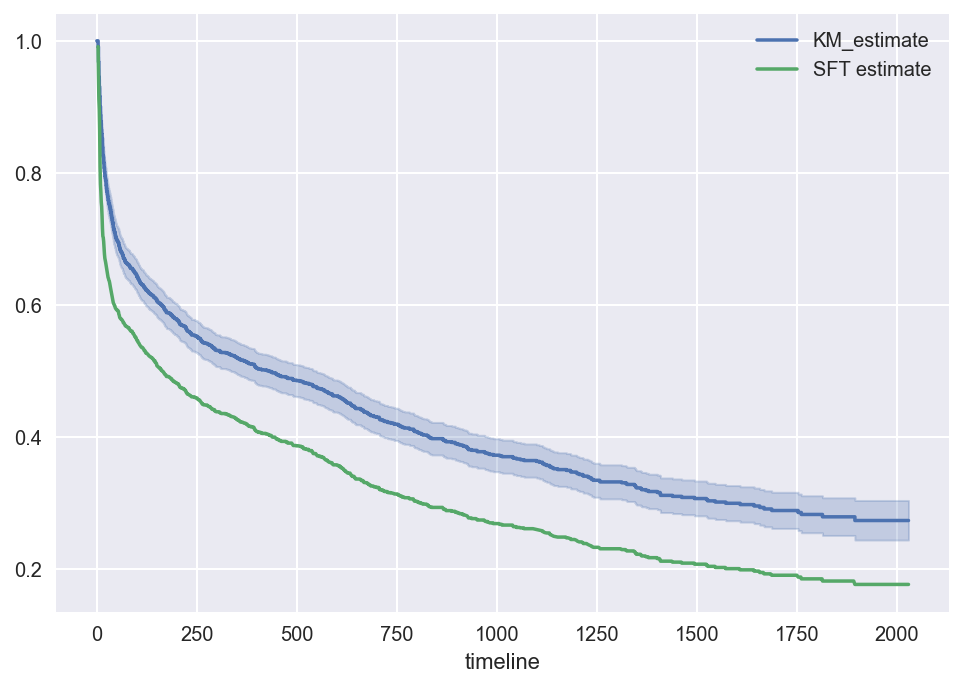

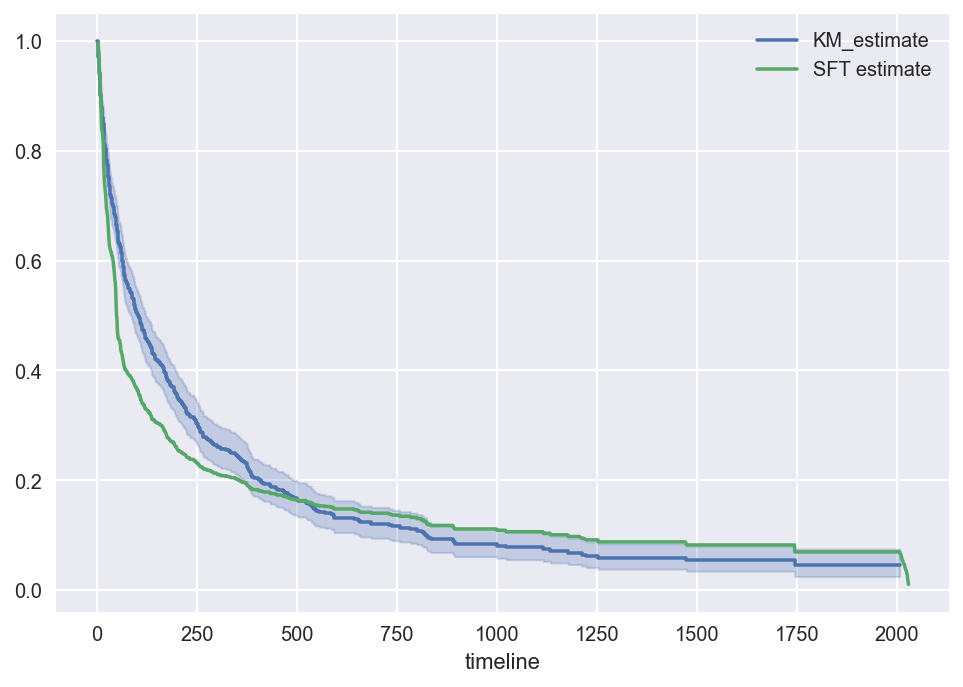

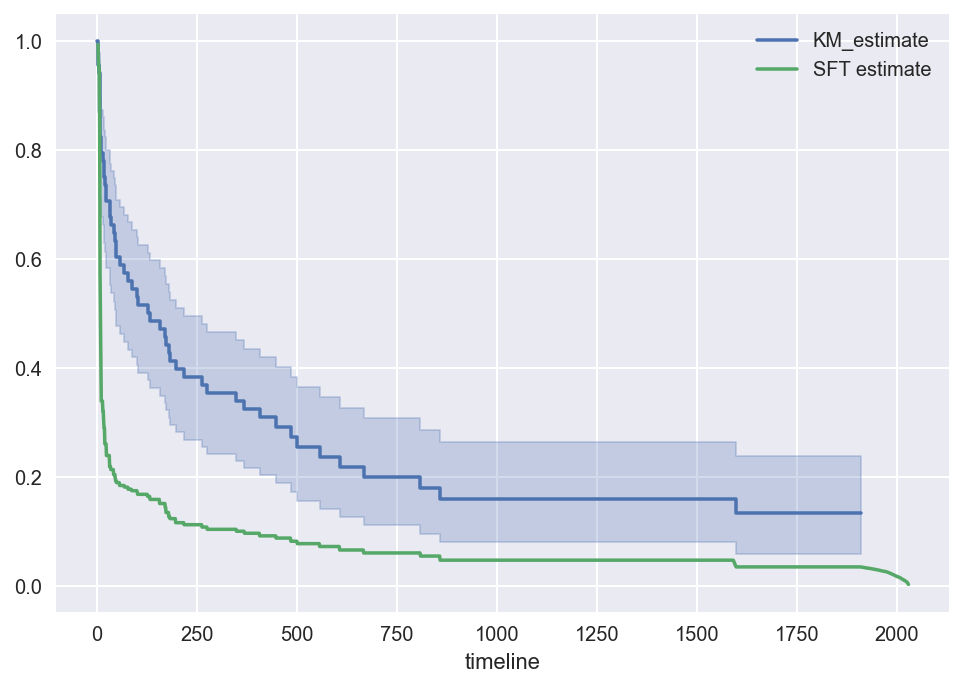

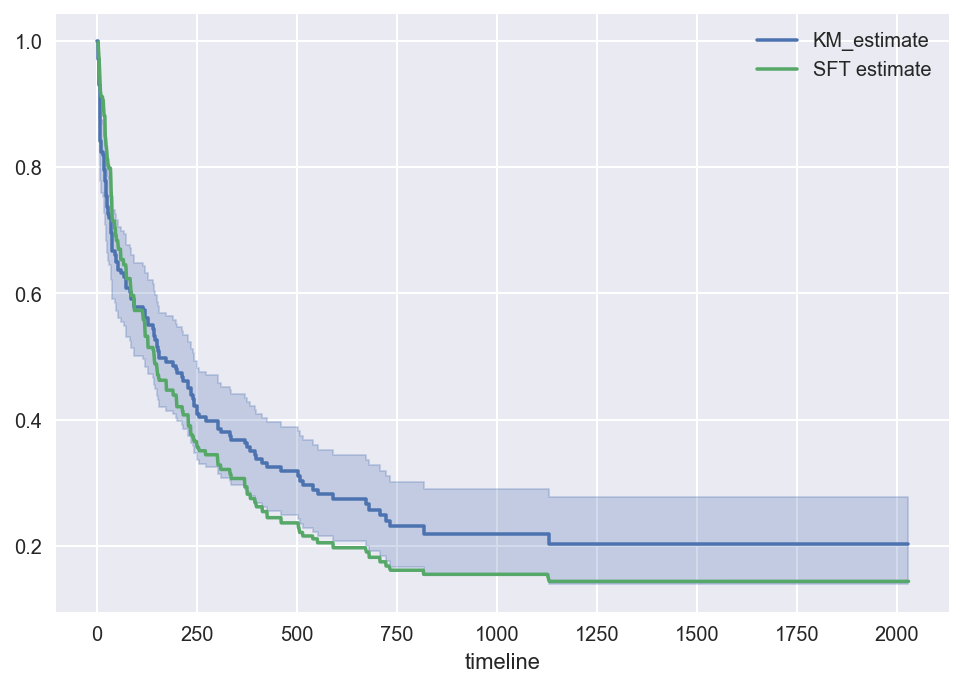

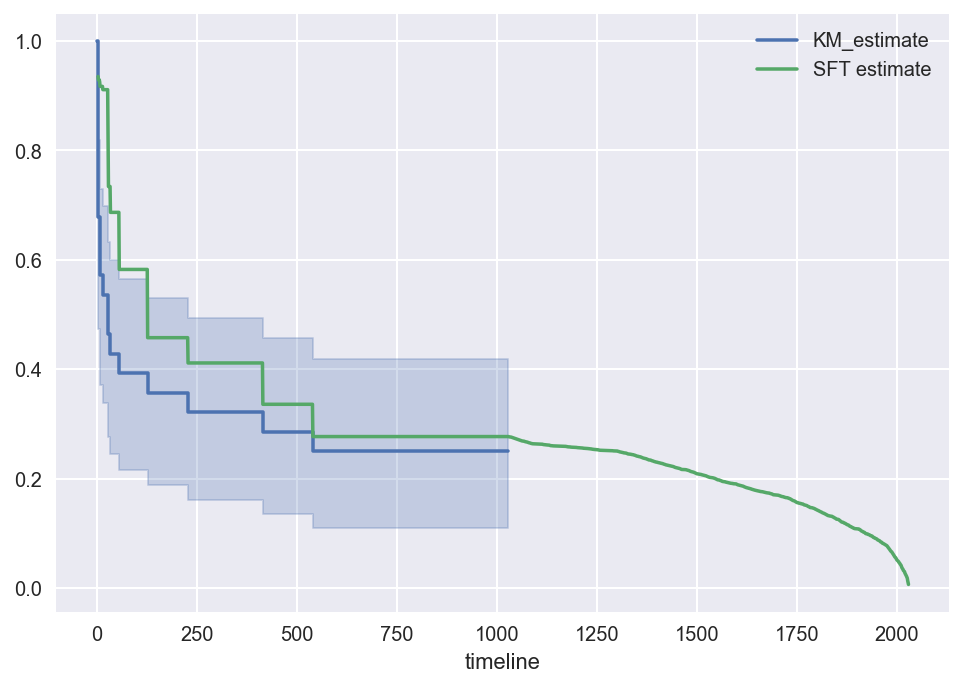

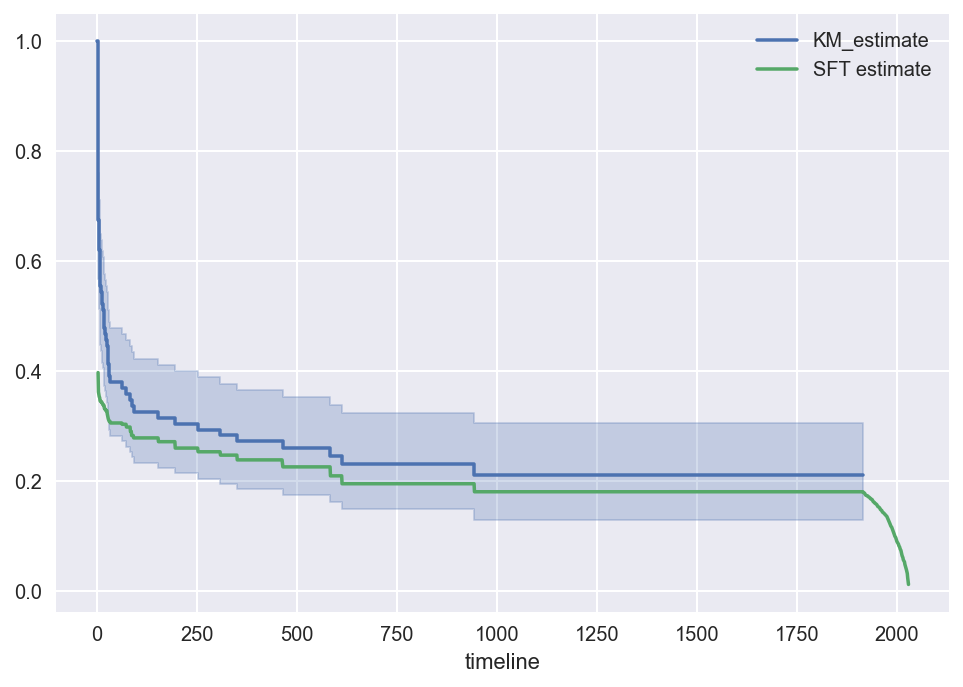

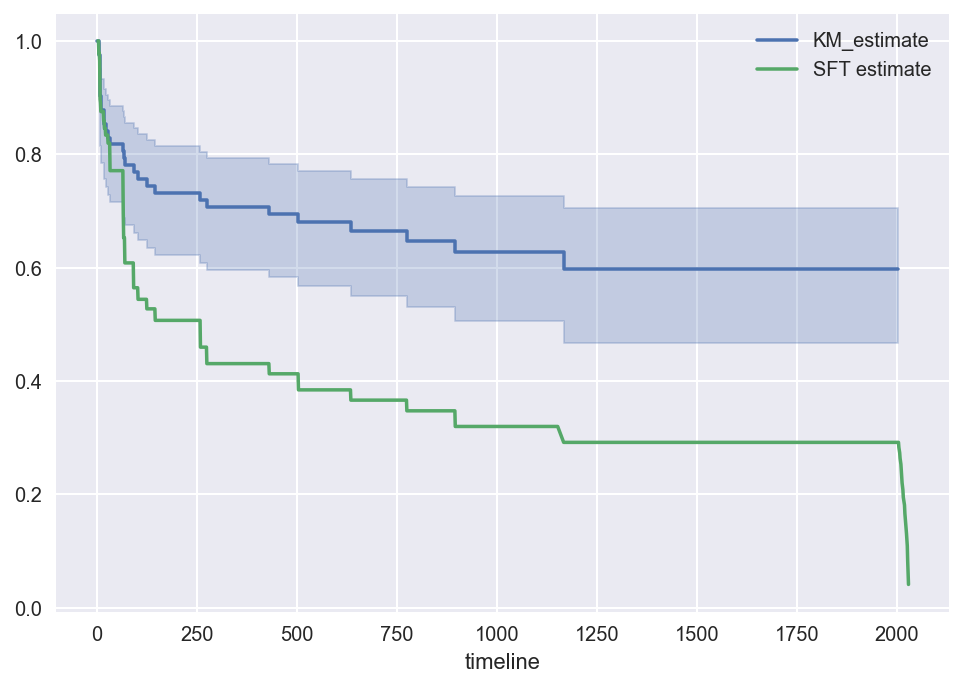

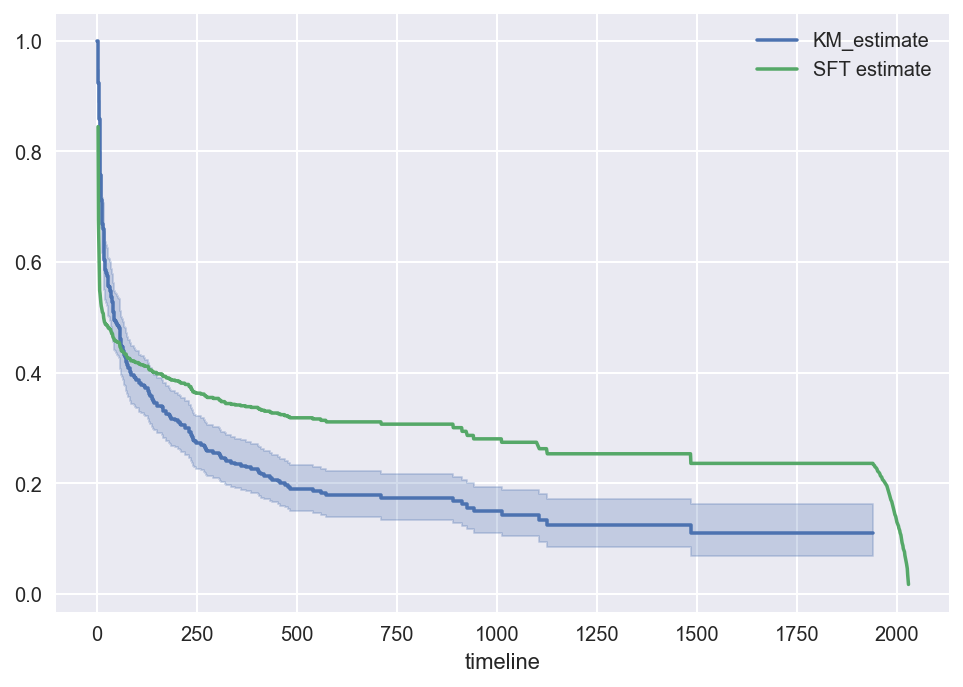

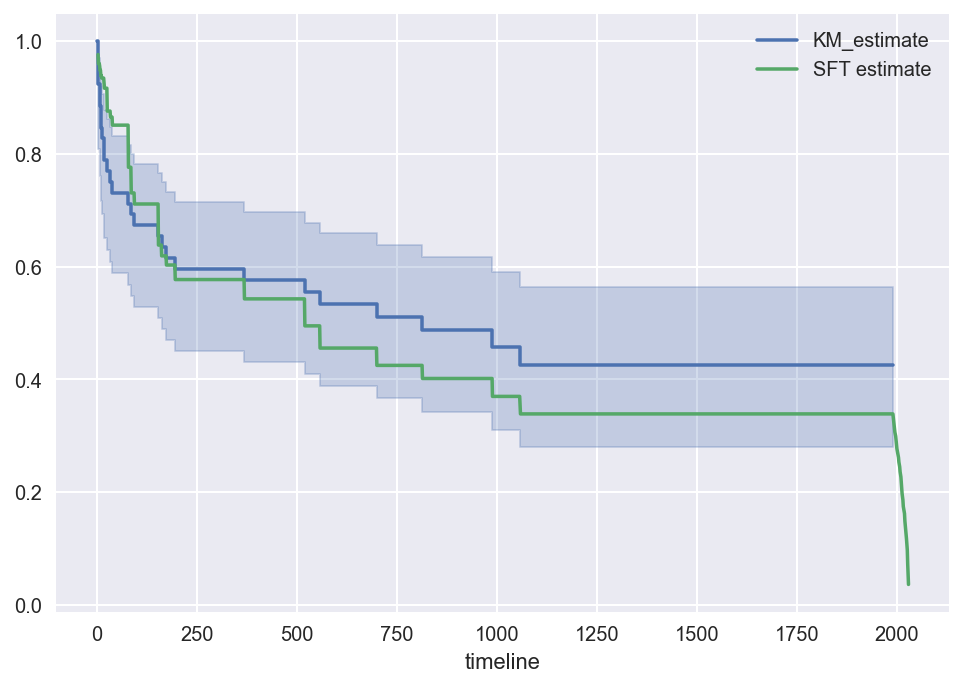

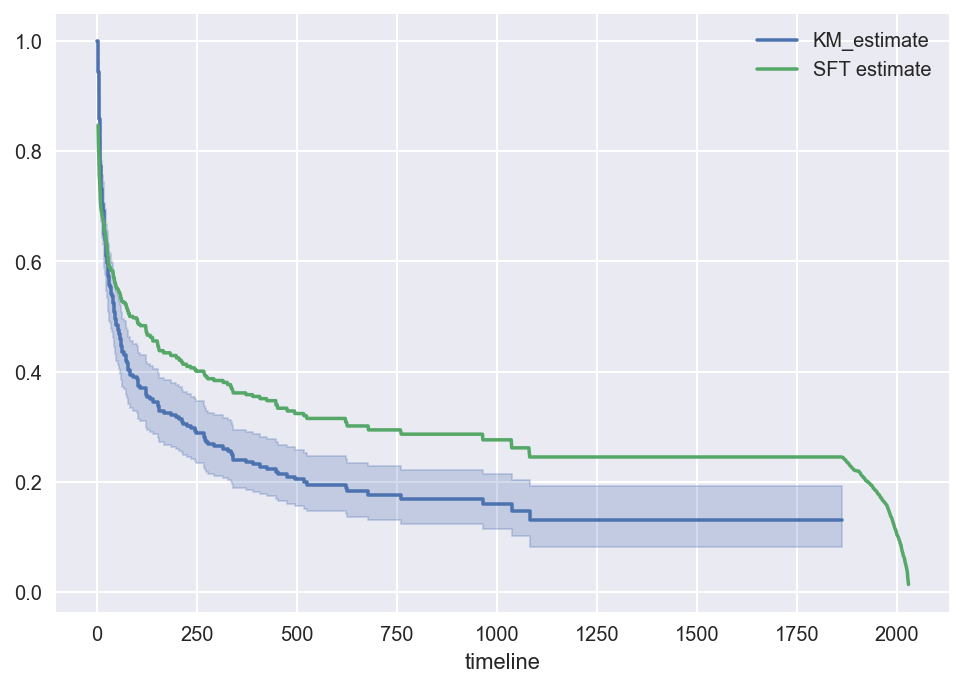

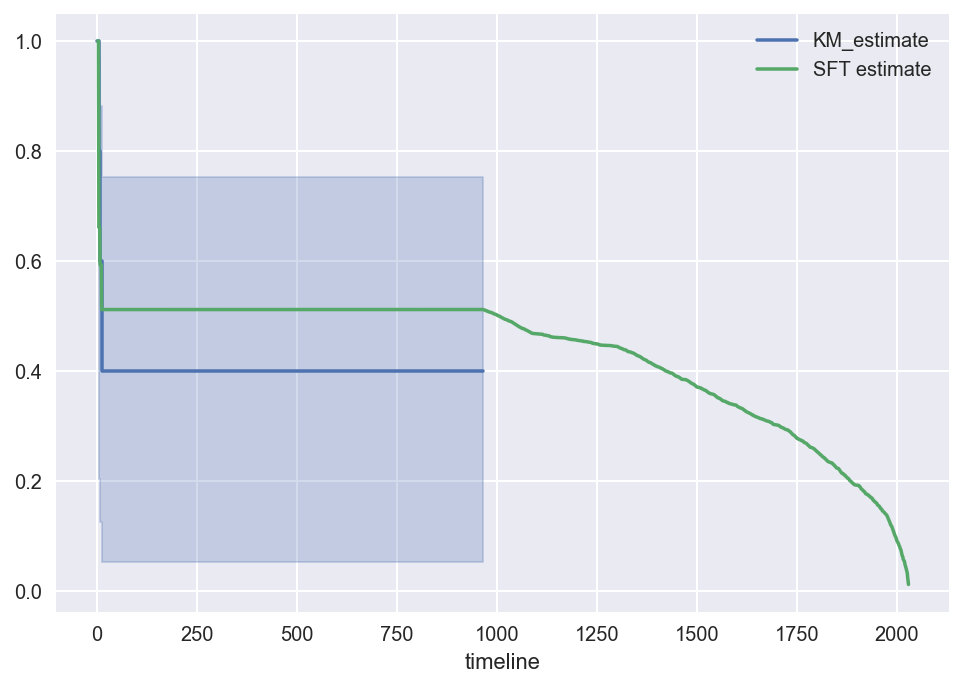

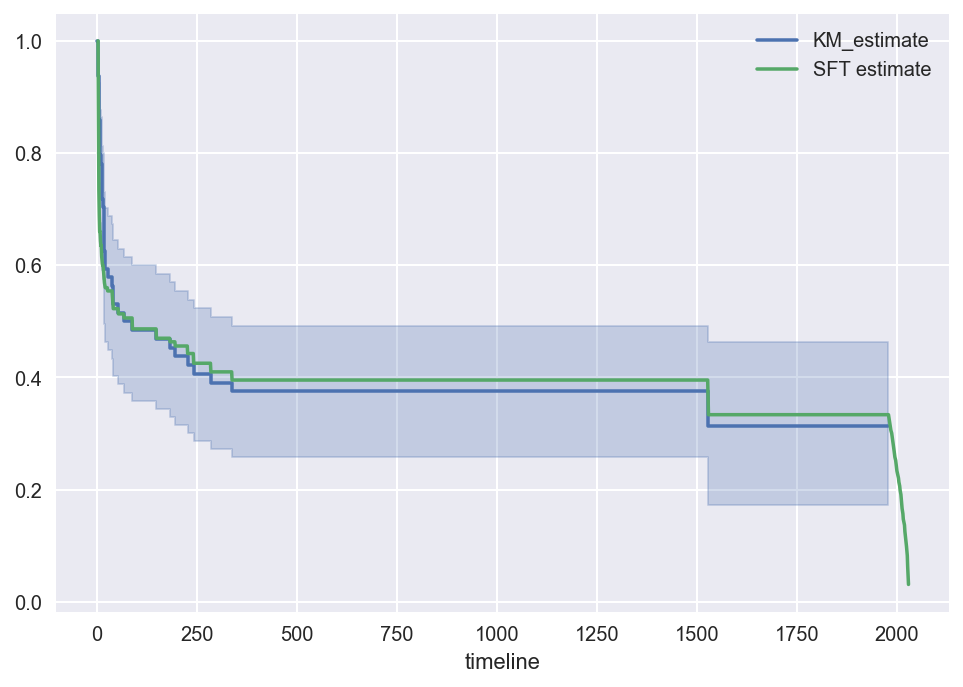

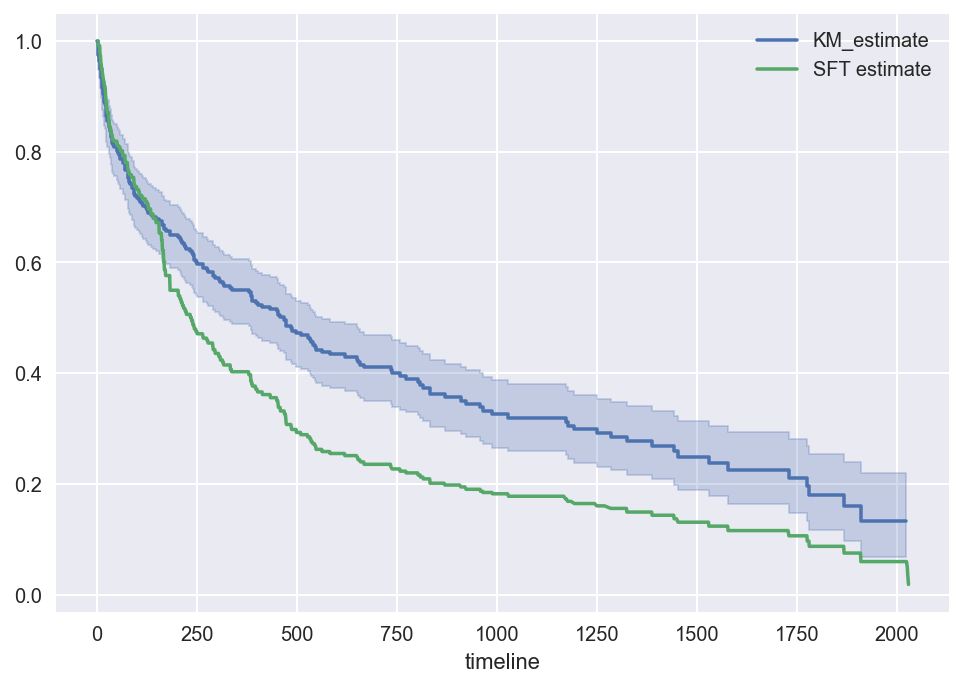

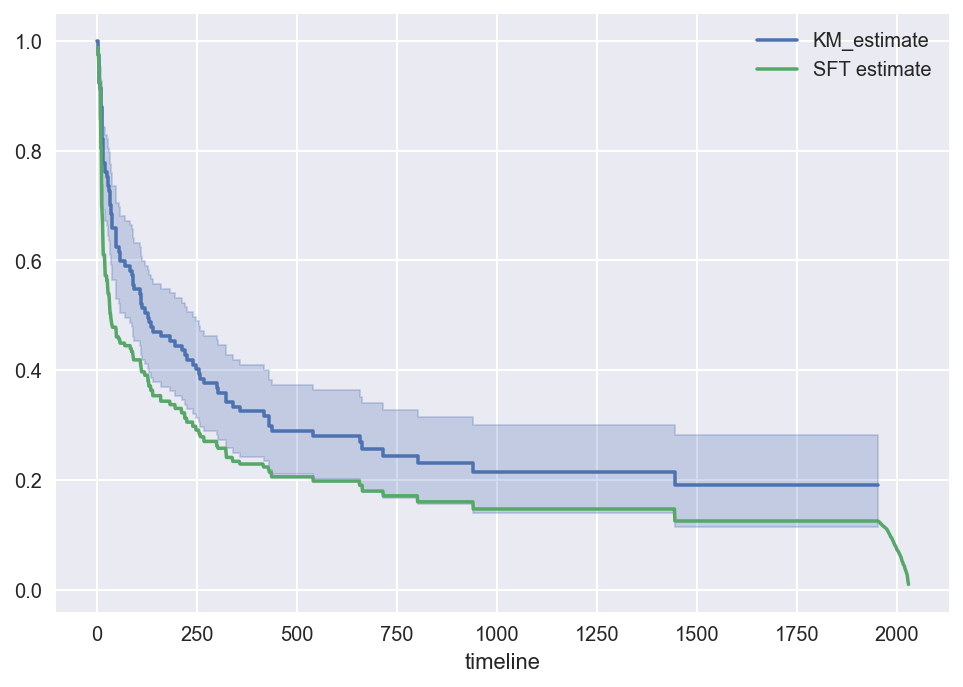

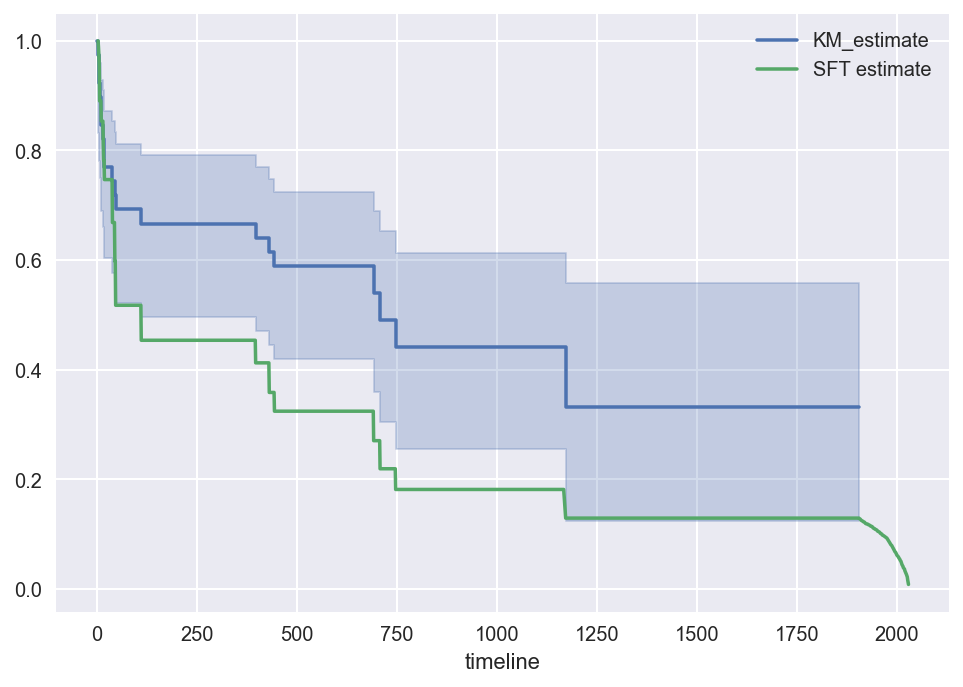

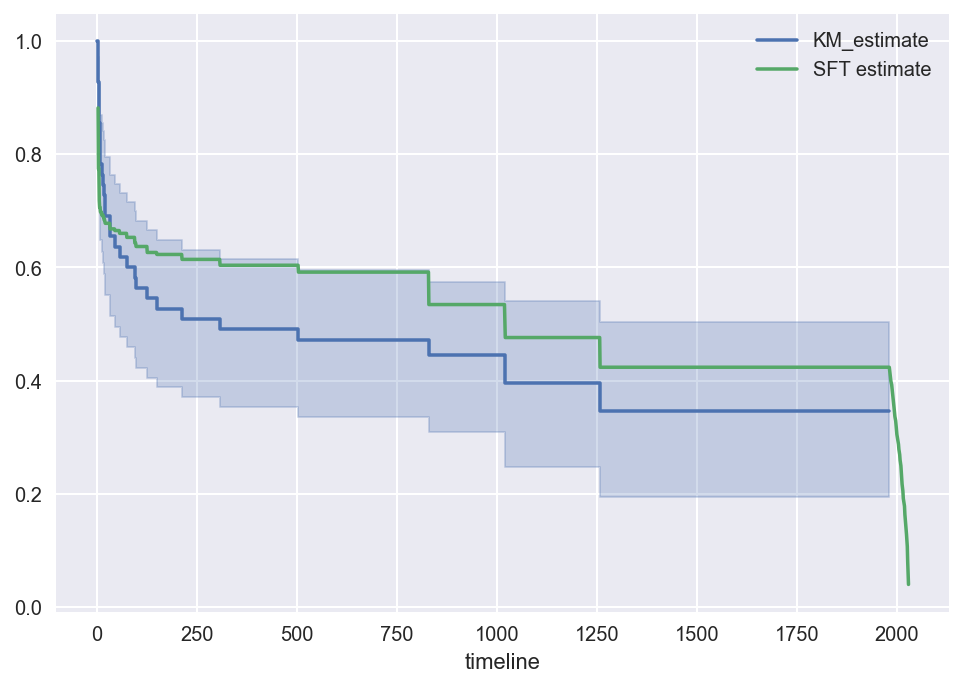

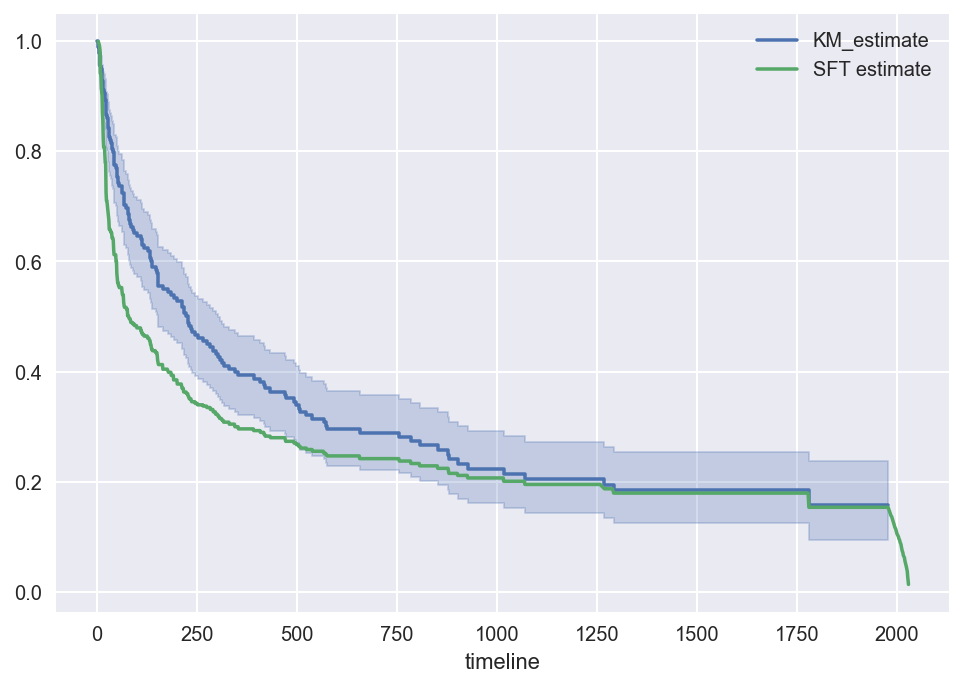

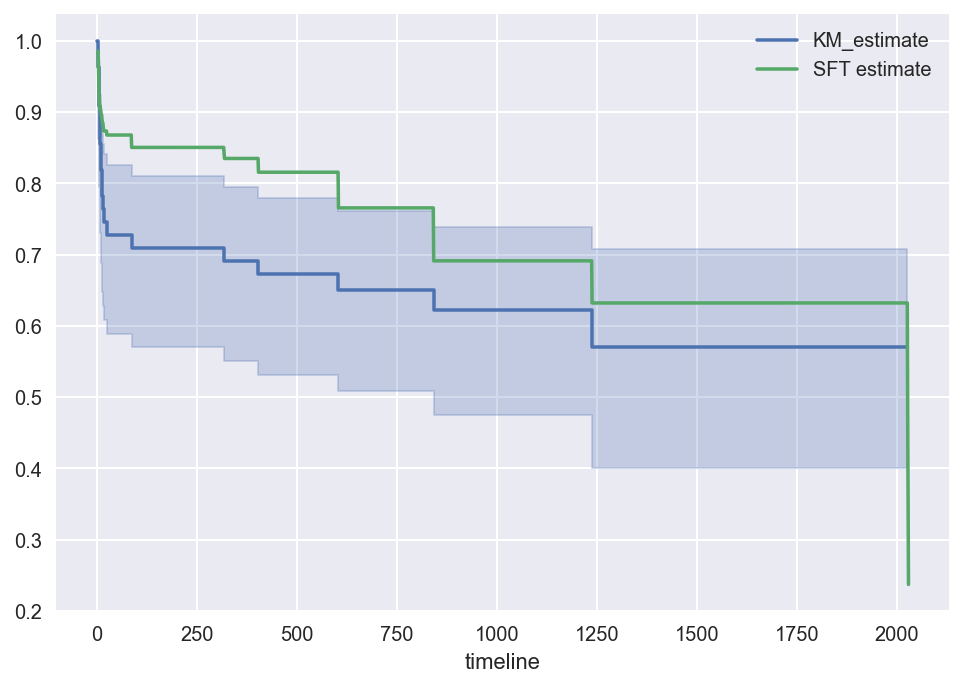

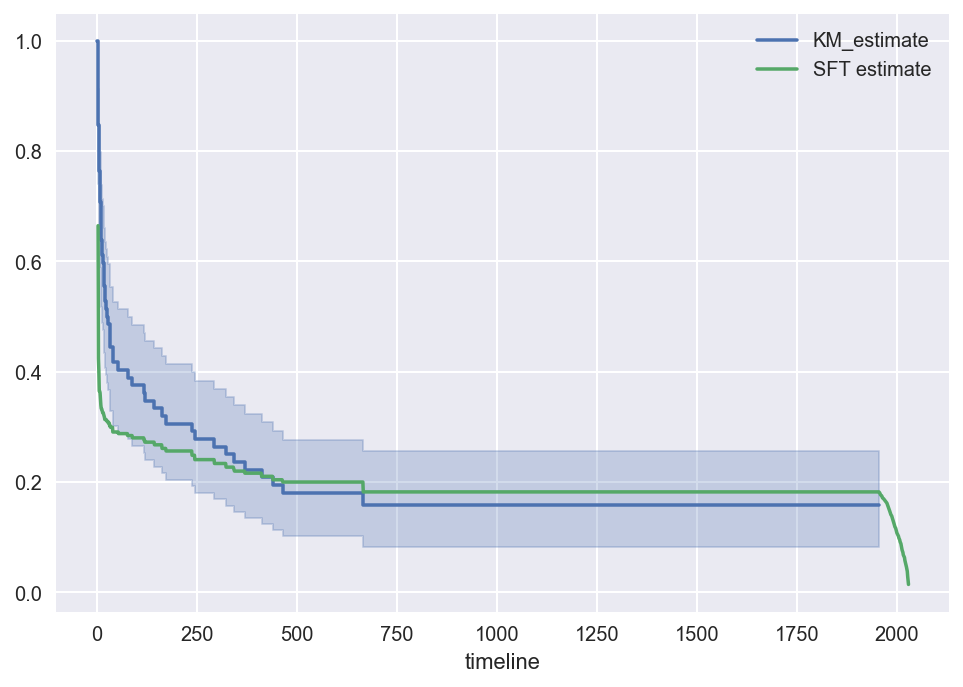

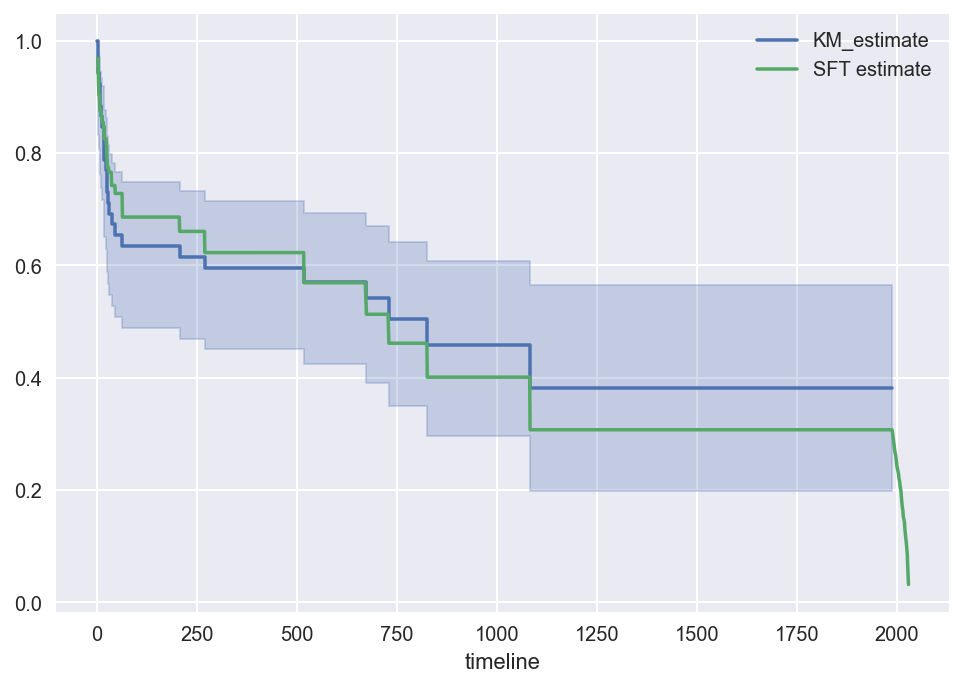

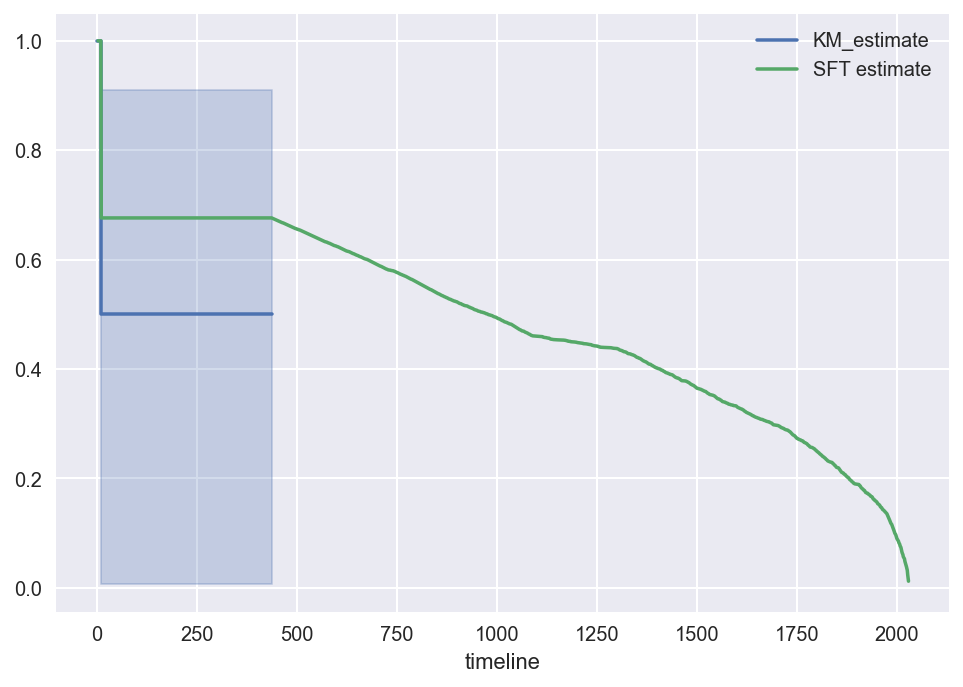

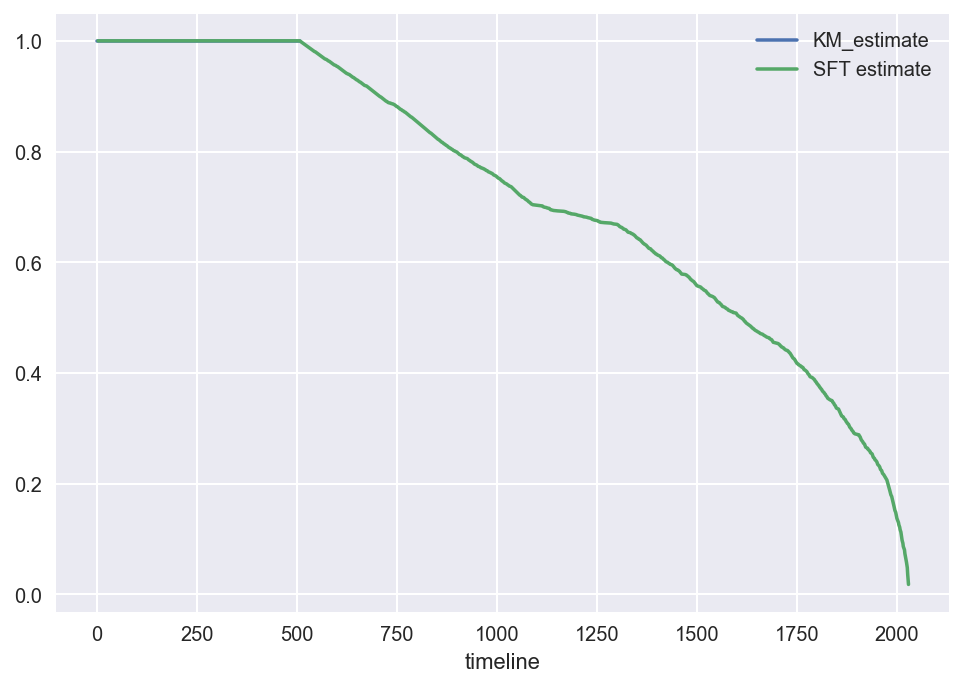

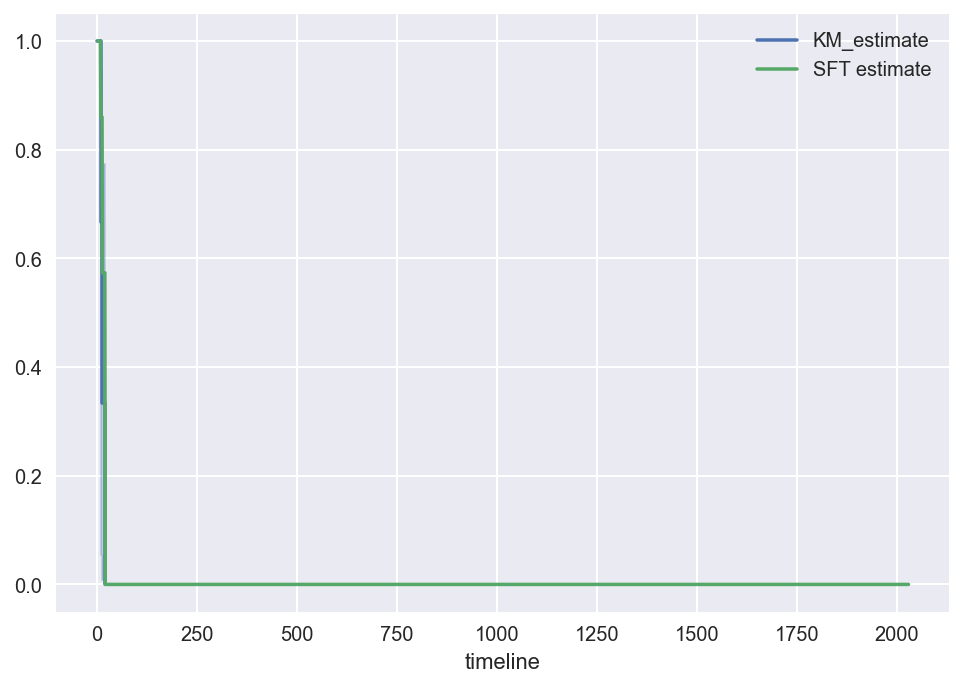

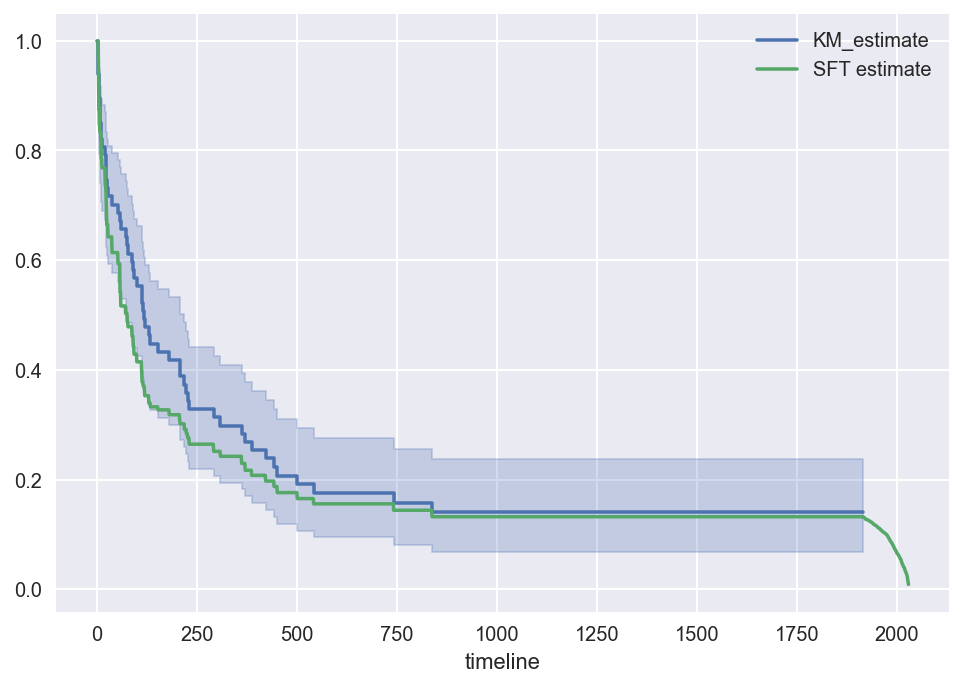

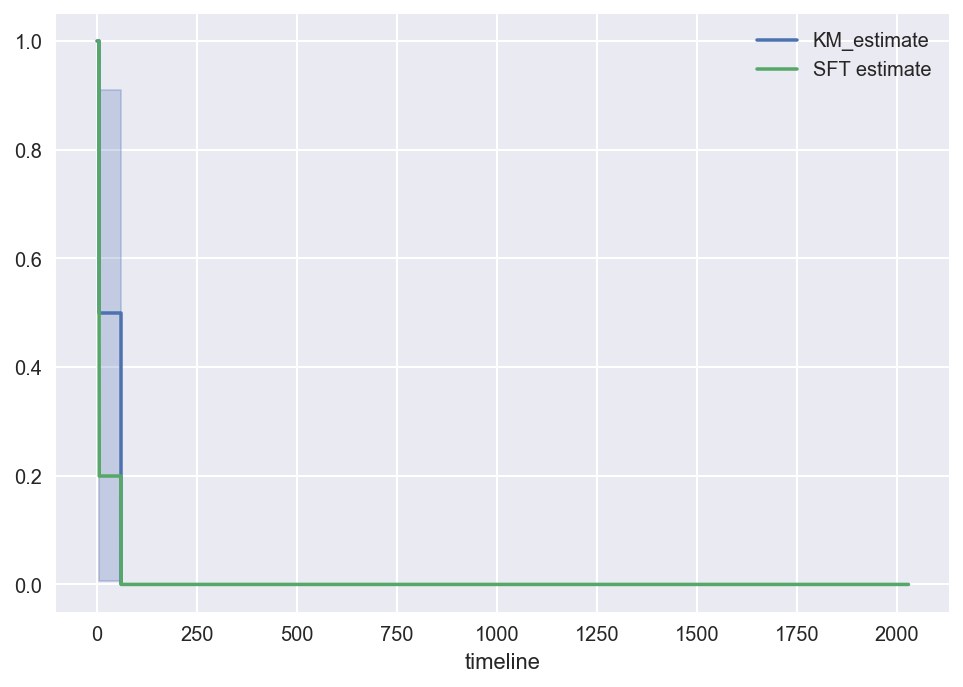

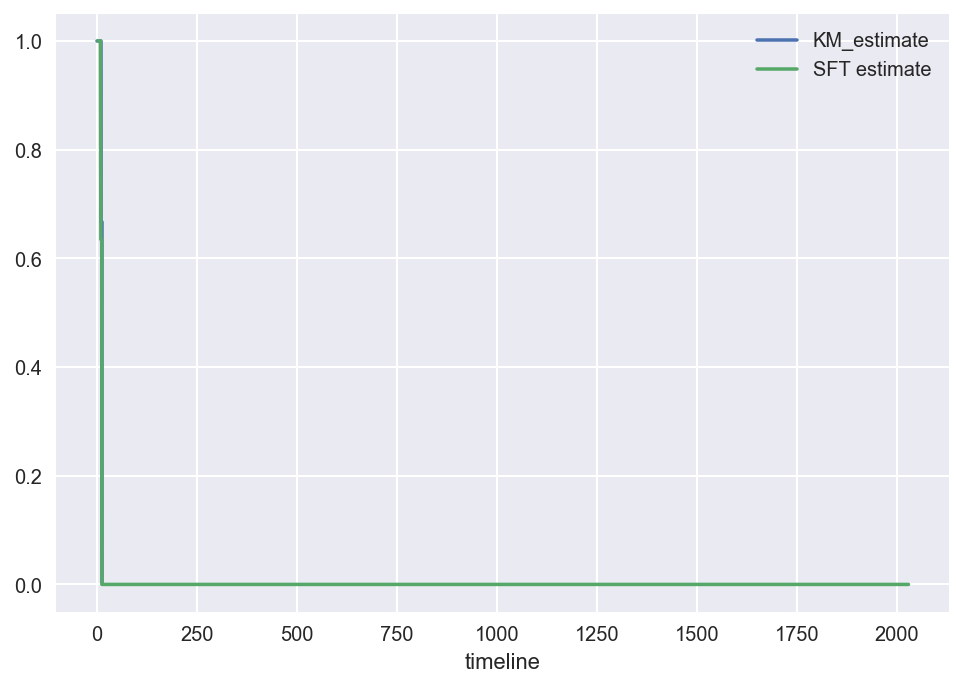

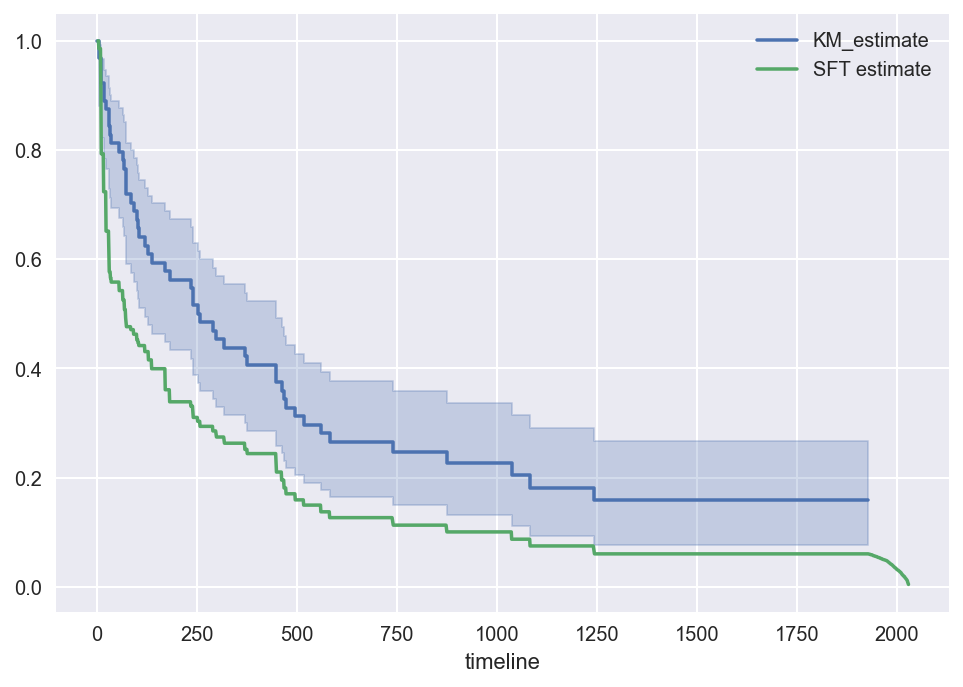

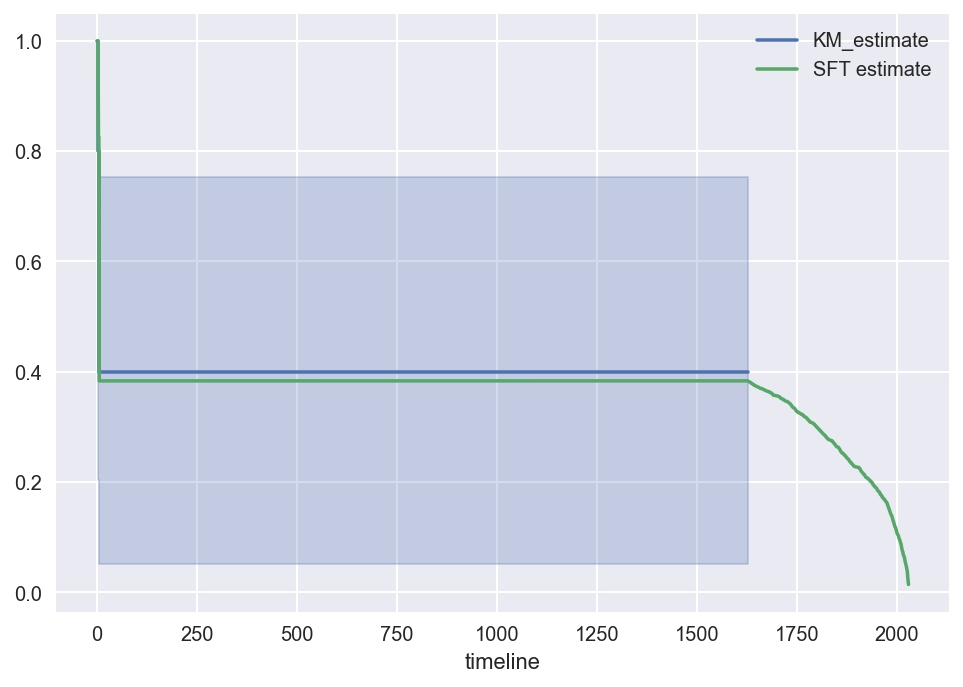

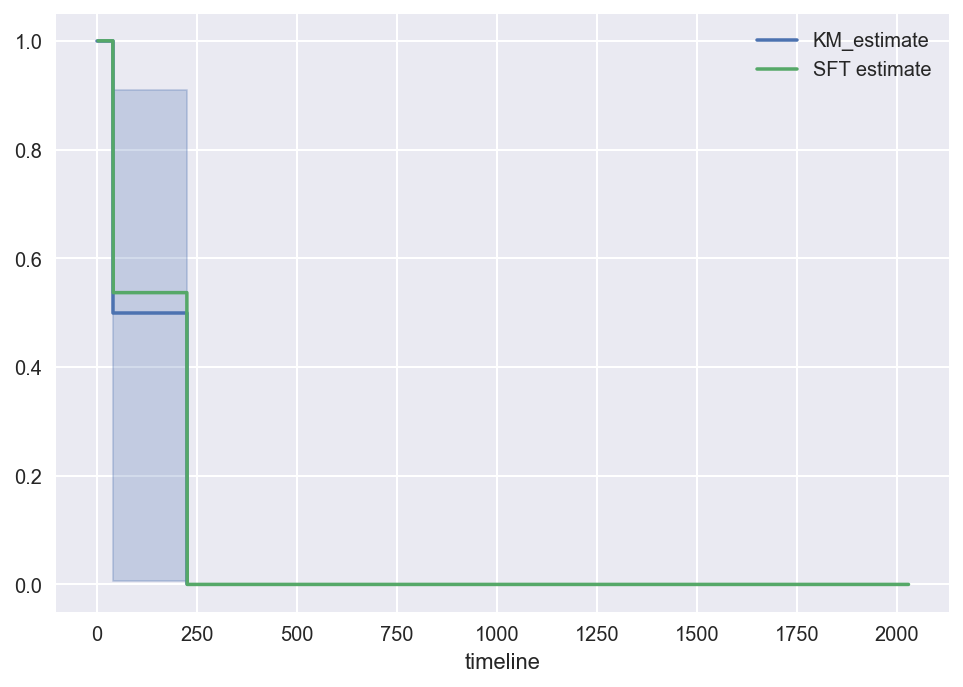

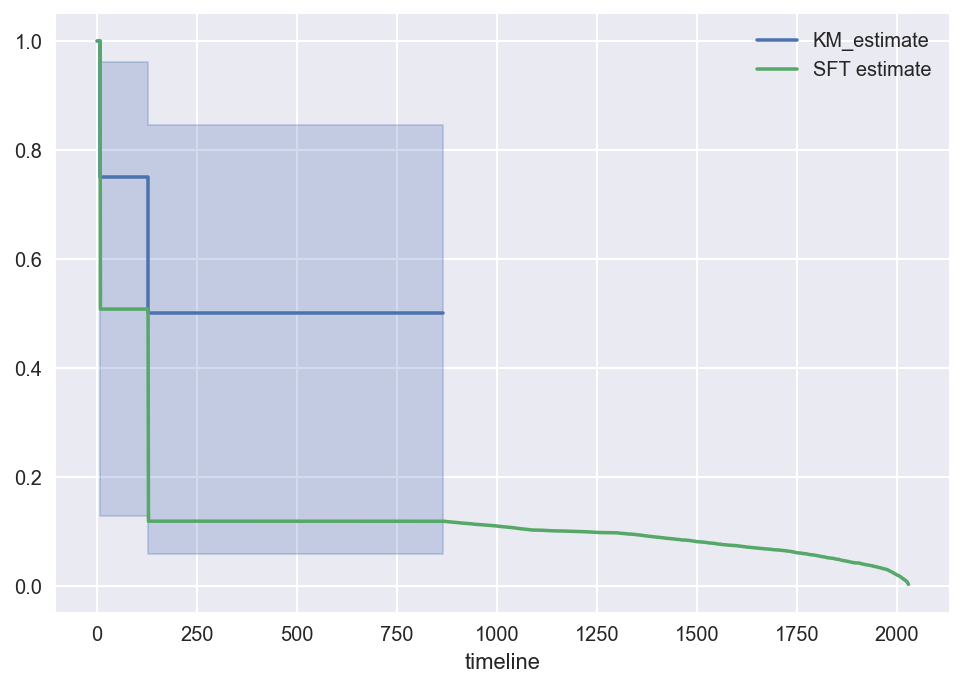

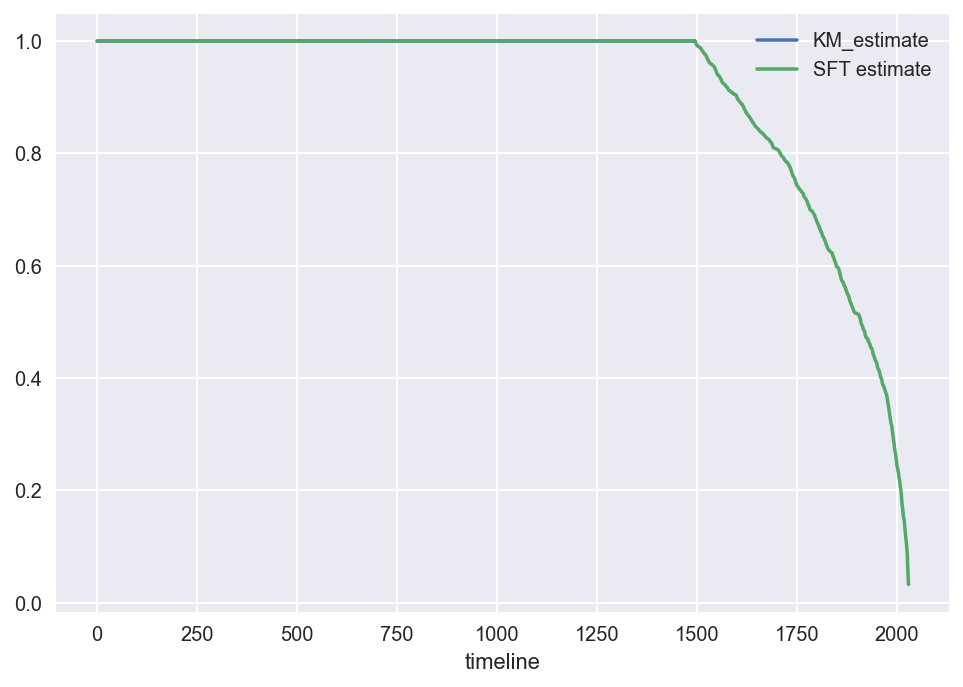

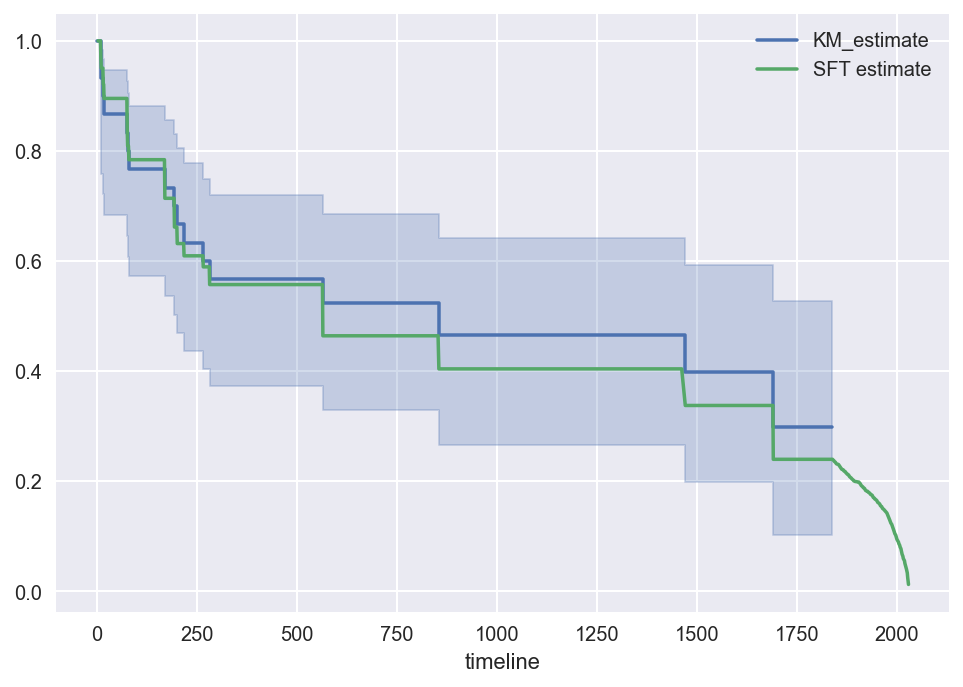

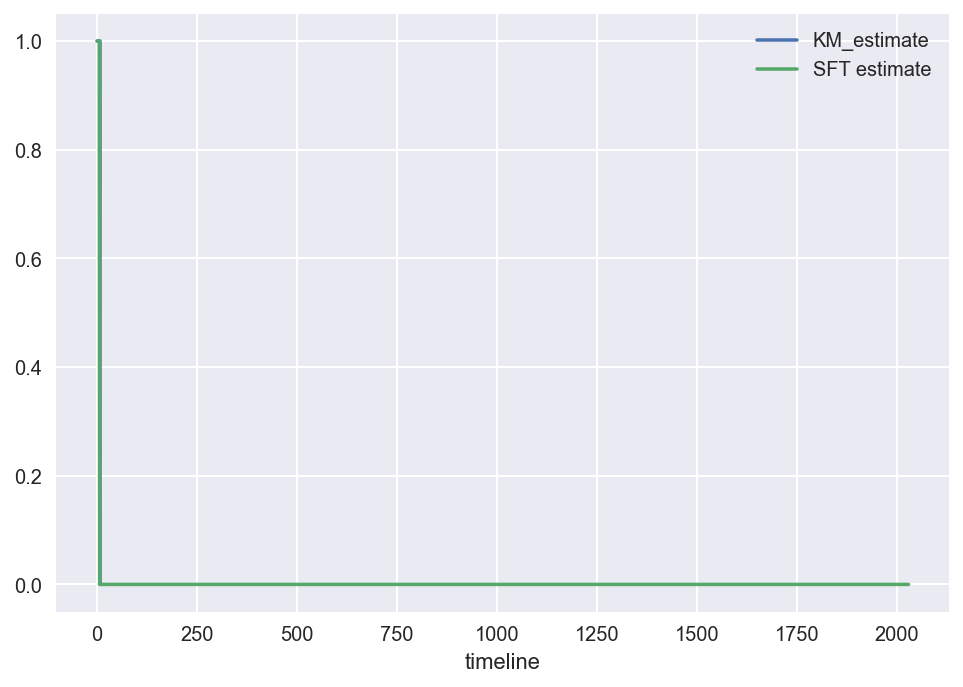

In [6]:
# this is just to compare each cluster's Kaplan-Meier survival curve with the summary fine-tuning survival curve
# (sometimes they are close but often they're quite different)
for exemplar_idx in range(n_exemplars):
    plt.figure()
    exemplar_kaplan_meier_curves[exemplar_idx].plot()
    plt.plot(duration_index, exemplar_SFT_survival_curves[exemplar_idx], label='SFT estimate')
    plt.legend()

In [7]:
# compute median survival times (look at where each survival curve crosses probability 1/2)
exemplar_SFT_median_survival_times = \
    compute_median_survival_times(exemplar_SFT_survival_curves, duration_index)

In [8]:
# discretizes features for heatmap visualization
transformed_features, transformed_feature_names = transform(dataset, raw_features)

/Users/georgehc/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


In [9]:
# gets 5 largest clusters
quadruples = \
    sorted([(idx, exemplar_sizes[idx],  exemplar_SFT_median_survival_times[idx], max_observed_times[idx])
            for idx in range(n_exemplars)], reverse=True, key=lambda x: x[1])[:5]
quadruples = sorted(quadruples, key=lambda x: x[2])  # sort by median survival time
quadruples

[(8, 341, 17.0, 1940.0),
 (2, 551, 50.0, 2007.0),
 (1, 1657, 164.0, 2029.0),
 (13, 271, 237.0, 2024.0),
 (0, 586, 244.0, 2022.0)]

In [10]:
# fraction of training data that are in the 5 largest clusters
np.sum([x[1] for x in quadruples]) / embeddings.shape[0]

0.6855877616747182

### Cluster feature heatmap plot

In [11]:
exemplars_to_visualize = np.array(quadruples).T[0].astype(int)
exemplars_to_visualize_median_survival_times = np.array(quadruples).T[2]
exemplars_to_visualize_max_observed_times = np.array(quadruples).T[3]

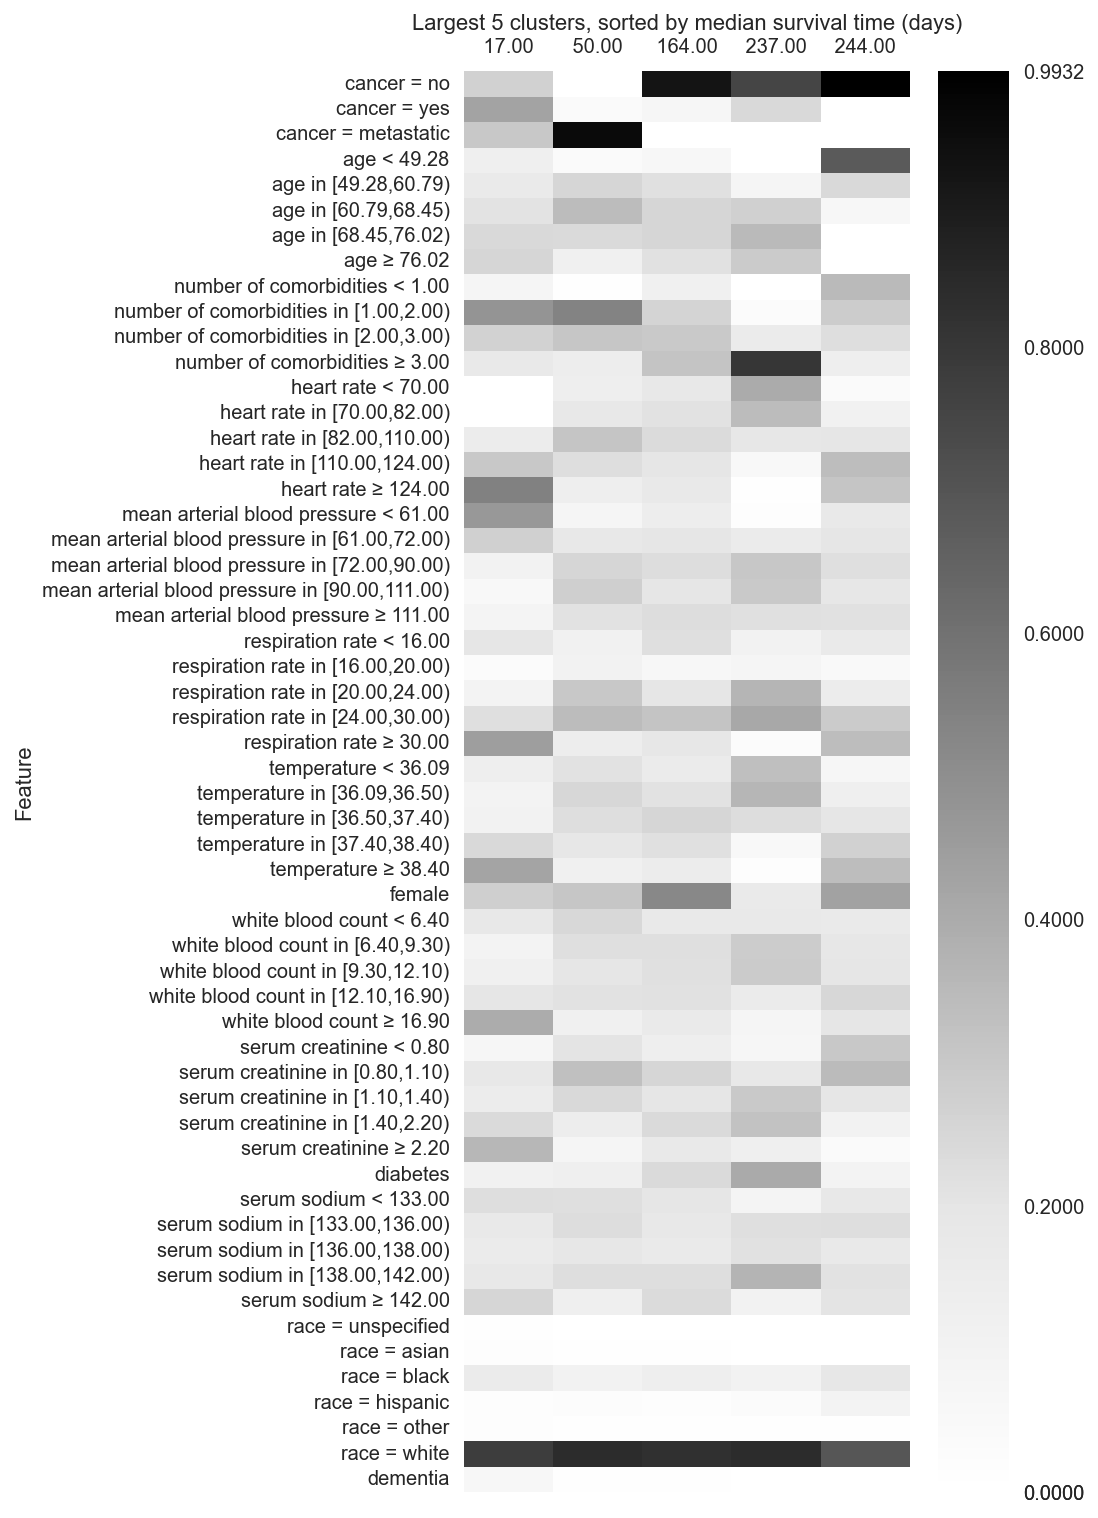

In [12]:
exemplar_assignments_in_terms_of_cluster_labels = np.zeros(raw_features.shape[0])
for idx, _ in enumerate(exemplar_assignments):
    exemplar_assignments_in_terms_of_cluster_labels[_] = idx

heatmap = np.zeros((len(transformed_feature_names), len(exemplars_to_visualize)))
for idx, exemplar_idx in enumerate(exemplars_to_visualize):
    heatmap[:, idx] = transformed_features[exemplar_assignments_in_terms_of_cluster_labels == exemplar_idx].mean(axis=0)

heatmap_plot(heatmap, exemplars_to_visualize_median_survival_times, transformed_feature_names,
             max_observed_times=exemplars_to_visualize_max_observed_times, units=units,
             custom_xlabel='Largest 5 clusters, sorted by median survival time (%s)' % units)
# plt.savefig('clusters-heatmap-top5-support.pdf', bbox_inches='tight')

### Cluster survival curve plot (using summary functions from summary fine-tuning)

Text(0, 0.5, 'Probability of survival')

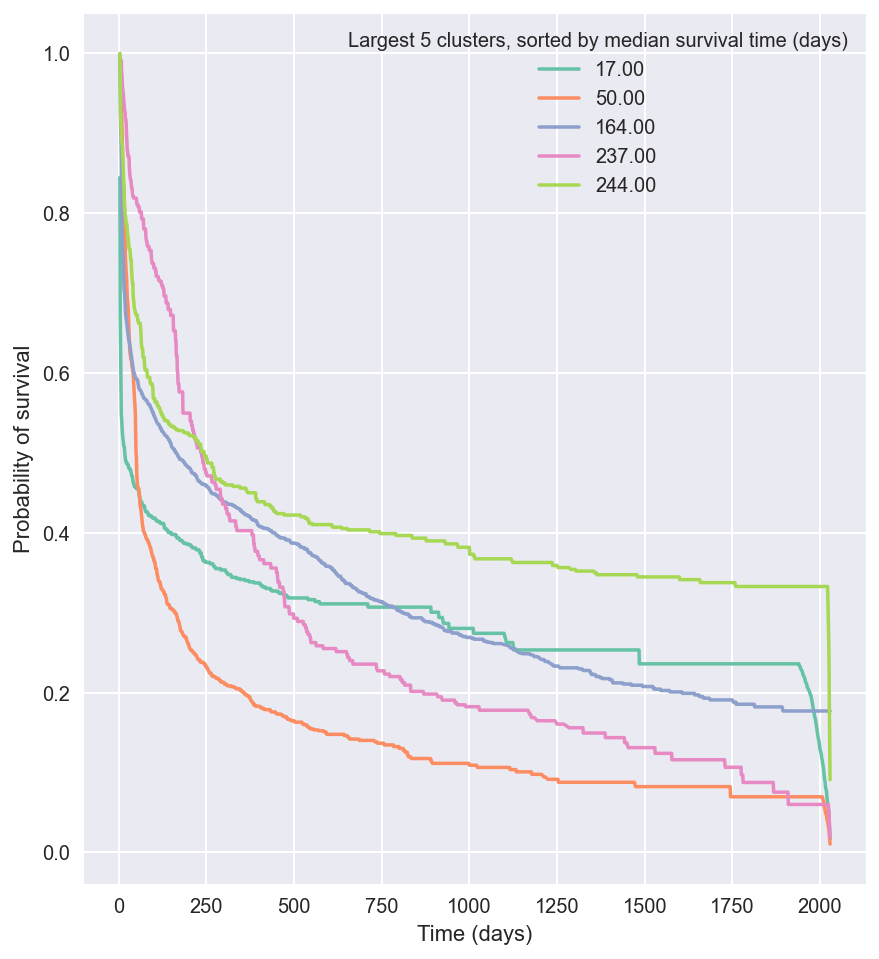

In [13]:
plt.figure(figsize=(7, 8))

# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set3.colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

for exemplar_idx, _, _, _ in quadruples:
    plt.plot(duration_index, exemplar_SFT_survival_curves[exemplar_idx], label='to be replaced')

L = plt.legend(title='Largest 5 clusters, sorted by median survival time (%s)' % units)
for idx, (exemplar_idx, _, _, max_observed_time) in enumerate(quadruples):
    if not np.isinf(exemplar_SFT_median_survival_times[exemplar_idx]):
        L.get_texts()[idx].set_text('%.2f' % exemplar_SFT_median_survival_times[exemplar_idx])
    else:
        L.get_texts()[idx].set_text('> %.2f' % max_observed_time)
plt.xlabel('Time (%s)' % units)
plt.ylabel('Probability of survival')
# plt.savefig('clusters-sft-survival-curves-top5-support.pdf', bbox_inches='tight')

### Clustering survival curve plot (using Kaplan-Meier curves -- corresponds to *not* using summary fine-tuning)

Text(0, 0.5, 'Probability of survival')

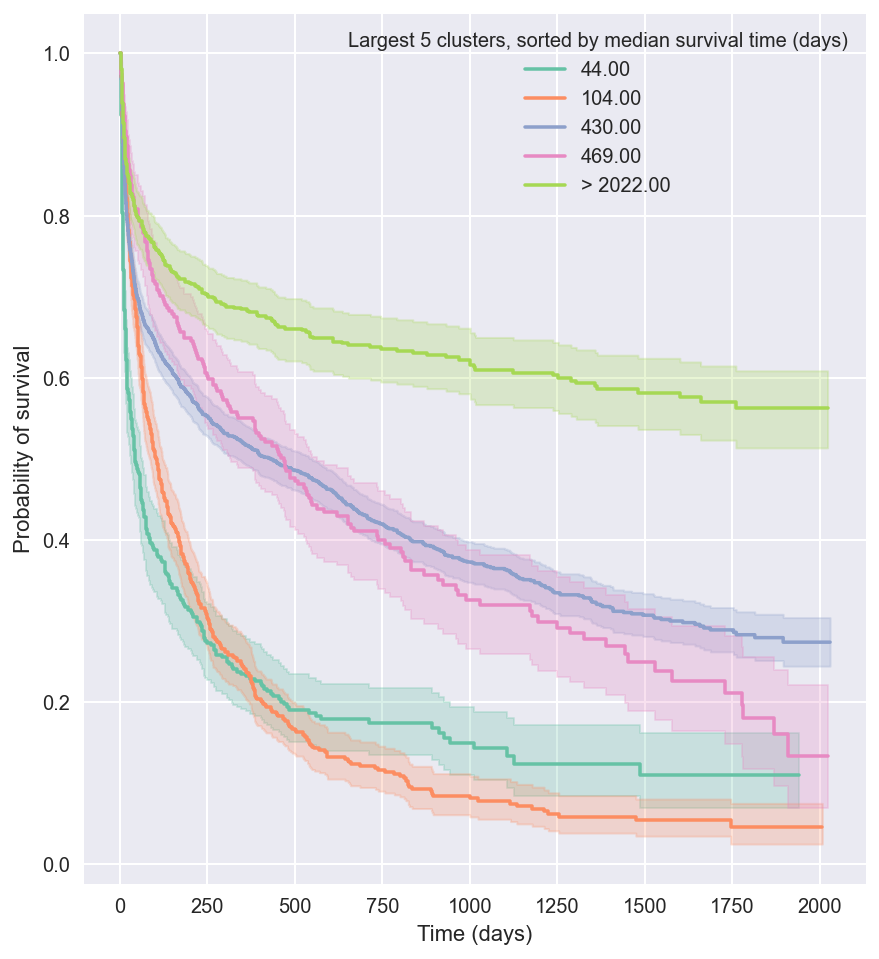

In [14]:
plt.figure(figsize=(7, 8))

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
for exemplar_idx, _, _, _ in quadruples:
    exemplar_kaplan_meier_curves[exemplar_idx].plot()
L = plt.legend(title='Largest 5 clusters, sorted by median survival time (%s)' % units)
for idx, (exemplar_idx, _, _, max_observed_time) in enumerate(quadruples):
    kaplan_meier_median_survival_time = exemplar_kaplan_meier_curves[exemplar_idx].median_survival_time_
    if not np.isinf(kaplan_meier_median_survival_time):
        L.get_texts()[idx].set_text('%.2f' % kaplan_meier_median_survival_time)
    else:
        L.get_texts()[idx].set_text('> %.2f' % max_observed_time)
plt.xlabel('Time (%s)' % units)
plt.ylabel('Probability of survival')
# plt.savefig('clusters-km-top5-support.pdf', bbox_inches='tight')

### Use agglomerative clustering to obtain superclusters for visualization

In [15]:
from sklearn.cluster import AgglomerativeClustering
n_superclusters = 10
cluster_model = AgglomerativeClustering(n_clusters=n_superclusters, linkage='complete')
cluster_model.fit(exemplar_embeddings)

AgglomerativeClustering(linkage='complete', n_clusters=10)

In [16]:
new_exemplar_assignments = [[] for cluster_idx in range(n_superclusters)]
for idx, _ in enumerate(exemplar_assignments):
    new_exemplar_assignments[cluster_model.labels_[idx]].extend(_)

In [17]:
[len(x) for x in new_exemplar_assignments]

[357, 2359, 278, 828, 416, 4, 1, 1, 641, 83]

In [18]:
new_weighted_survival_curves = []
new_max_observed_times = []
for cluster_idx in range(n_superclusters):
    T, E = labels[new_exemplar_assignments[cluster_idx]].T
    new_max_observed_times.append(T.max())
    
    mask = (cluster_model.labels_ == cluster_idx)
    exemplar_indices = np.where(mask)[0]
    weights = []
    for exemplar_idx in exemplar_indices:
        weights.append(exemplar_sizes[exemplar_idx])
    weights = np.array(weights, dtype=float)
    weights = weights / weights.sum()
    weighted_survival_curve = np.zeros(exemplar_SFT_survival_curves.shape[1])
    for exemplar_idx, weight in zip(exemplar_indices, weights):
        weighted_survival_curve += weight * exemplar_SFT_survival_curves[exemplar_idx]
    new_weighted_survival_curves.append(weighted_survival_curve)

new_median_survival_times = \
    compute_median_survival_times(new_weighted_survival_curves, duration_index)

new_exemplar_assignments_in_terms_of_cluster_labels = np.zeros(raw_features.shape[0])
for idx, _ in enumerate(new_exemplar_assignments):
    new_exemplar_assignments_in_terms_of_cluster_labels[_] = idx

new_quadruples = \
    [(cluster_idx,
      len(new_exemplar_assignments[cluster_idx]),
      new_median_survival_times[cluster_idx],
      new_max_observed_times[cluster_idx])
     for cluster_idx in range(n_superclusters)]
new_quadruples = sorted(new_quadruples, key=lambda x: x[3])
new_quadruples = sorted(new_quadruples, reverse=False, key=lambda x: x[2])

new_exemplars_to_visualize = np.array(new_quadruples).T[0].astype(int)
new_exemplars_to_visualize_median_survival_times = np.array(new_quadruples).T[2]
new_exemplars_to_visualize_max_observed_times = np.array(new_quadruples).T[3]

new_heatmap = np.zeros((len(transformed_feature_names), len(new_exemplars_to_visualize)))
for idx, cluster_idx in enumerate(new_exemplars_to_visualize):
    new_heatmap[:, idx] = transformed_features[
        new_exemplar_assignments_in_terms_of_cluster_labels == cluster_idx].mean(axis=0)

new_quadruples

[(6, 1, 7.0, 7.0),
 (4, 416, 10.0, 1955.0),
 (3, 828, 60.0, 2029.0),
 (2, 278, 126.0, 1862.0),
 (1, 2359, 150.0, 2029.0),
 (5, 4, 226.0, 437.0),
 (8, 641, 253.0, 2022.0),
 (0, 357, 259.0, 2026.0),
 (9, 83, 369.0, 1990.0),
 (7, 1, 1610.0, 507.0)]

Text(0, 0.5, 'Probability of survival')

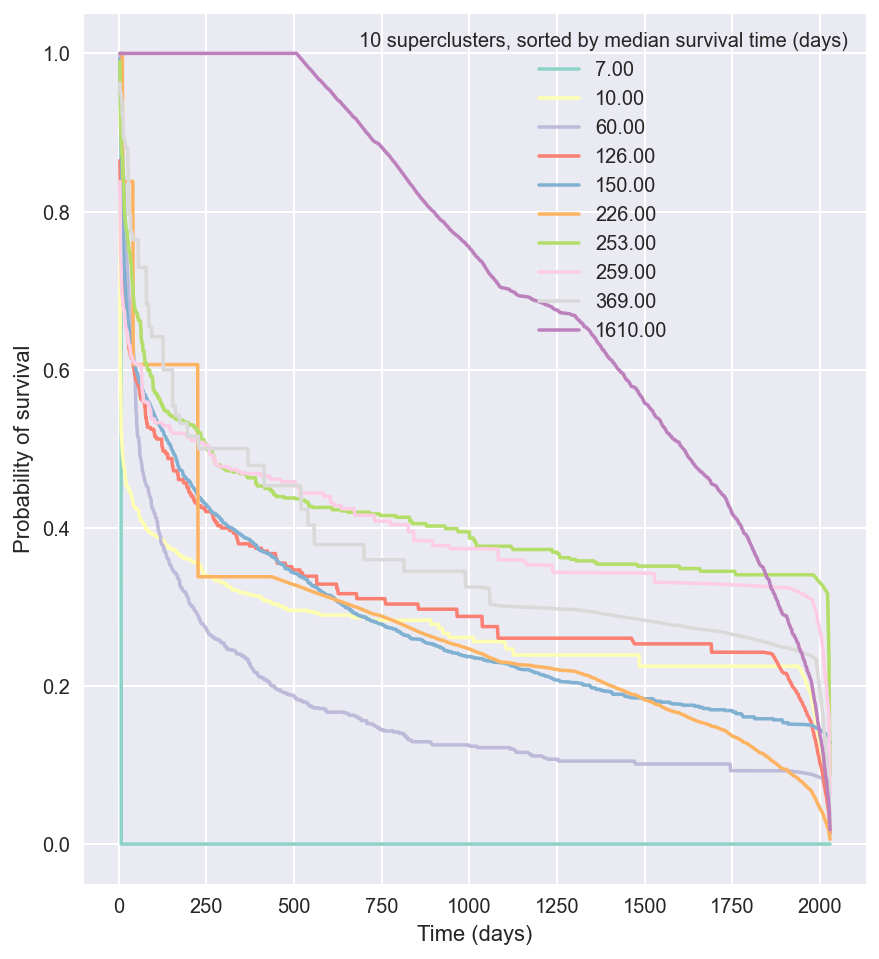

In [19]:
plt.figure(figsize=(7, 8))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set3.colors)
for cluster_idx, _, _, _ in new_quadruples:
    plt.plot(duration_index, new_weighted_survival_curves[cluster_idx], label='to be replaced')
L = plt.legend(title='10 superclusters, sorted by median survival time (%s)' % units)
for idx, (_, _, exemplar_median_survival_time, max_observed_time) in enumerate(new_quadruples):
    if not np.isinf(exemplar_median_survival_time):
        L.get_texts()[idx].set_text('%.2f' % exemplar_median_survival_time)
    else:
        L.get_texts()[idx].set_text('> %.2f' % max_observed_time)
plt.xlabel('Time (%s)' % units)
plt.ylabel('Probability of survival')
# plt.savefig('superclusters-sft-km-support.pdf', bbox_inches='tight')

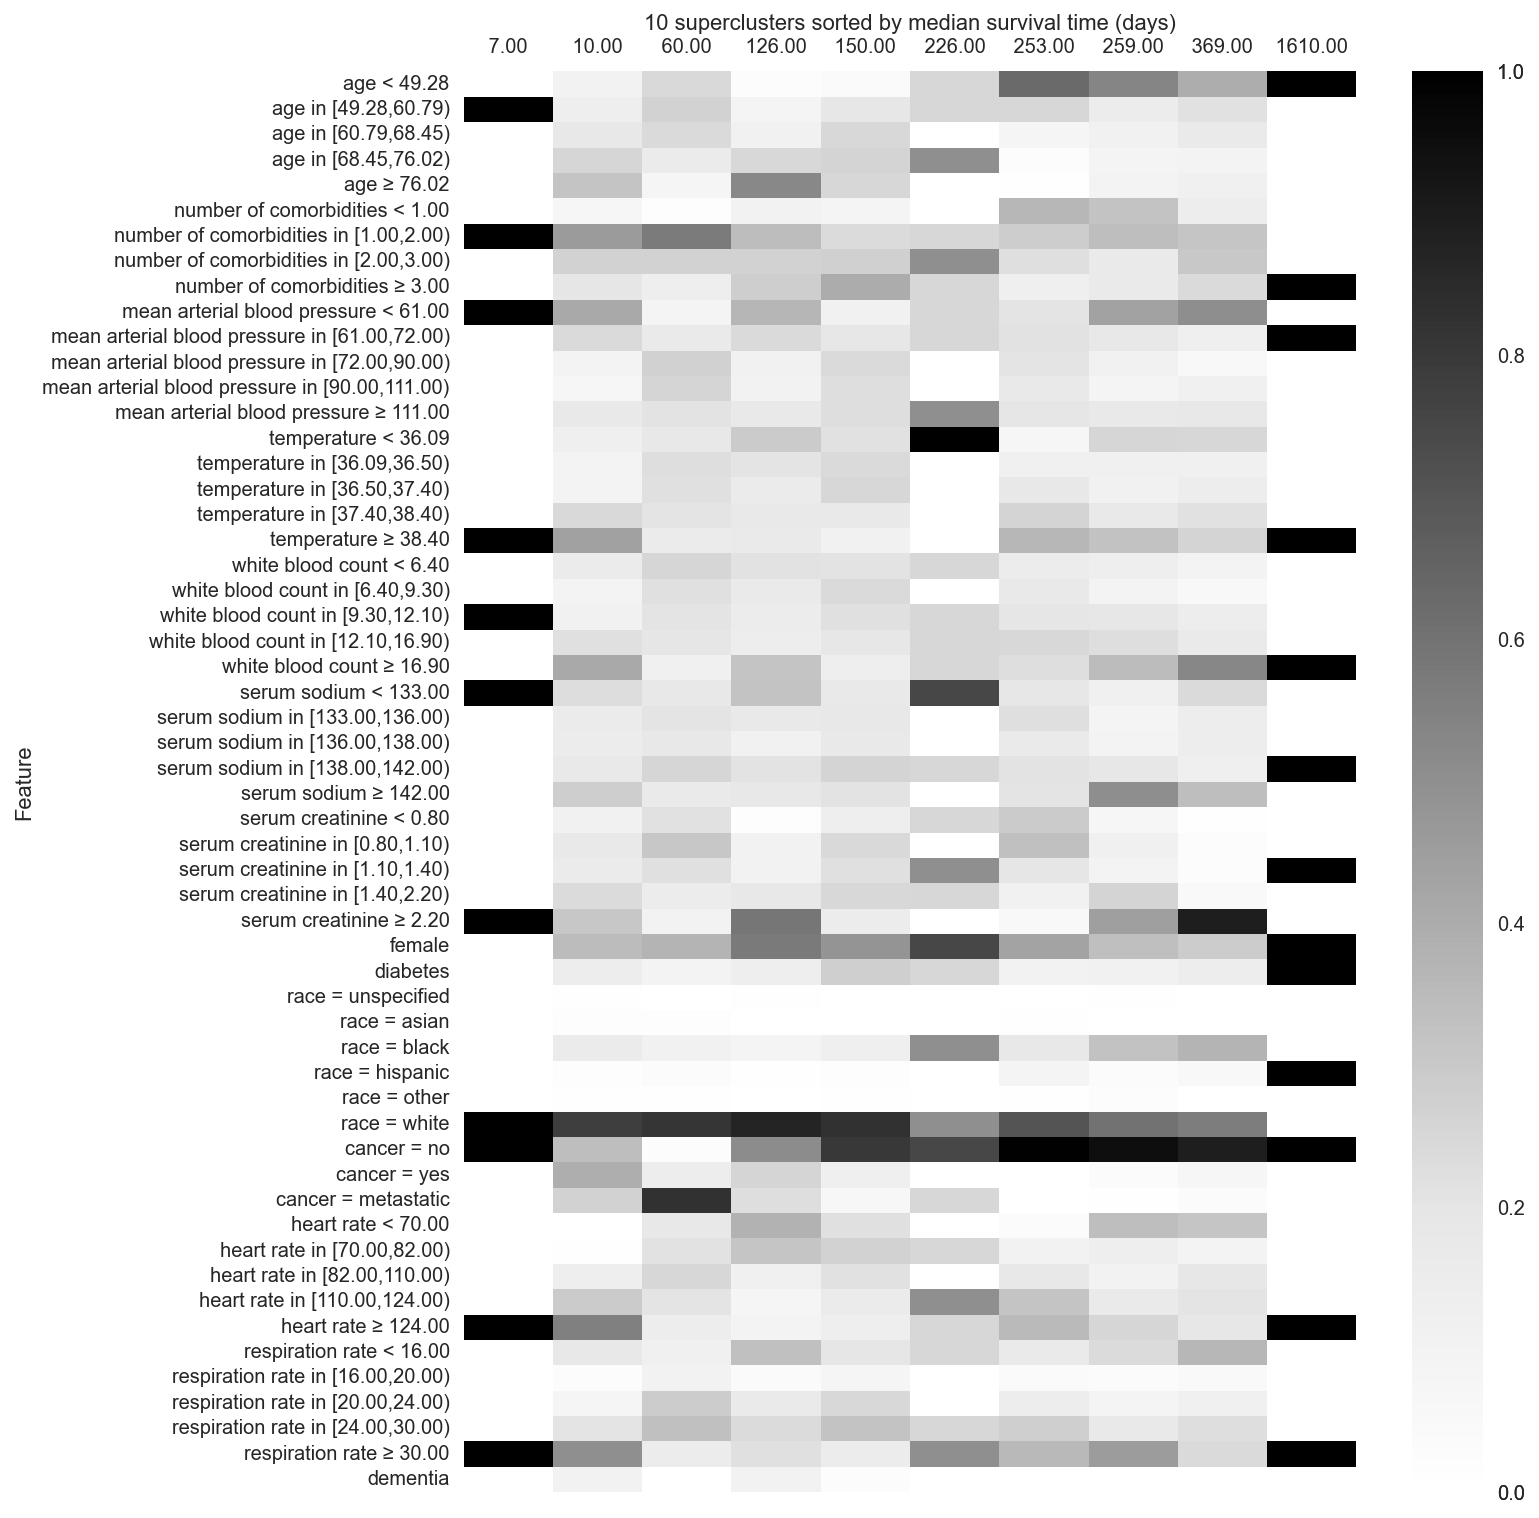

In [20]:
heatmap_plot(new_heatmap, new_exemplars_to_visualize_median_survival_times,
             transformed_feature_names,
             max_observed_times=new_exemplars_to_visualize_max_observed_times,
             units=units, max_features_to_display=60,
             custom_xlabel='10 superclusters sorted by median survival time (days)')
# plt.savefig('superclusters-sft-heatmap-support.pdf', bbox_inches='tight')